In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [12]:
#Finding the columns and types in the measurement table
MInspect = inspect(engine)
columns = MInspect.get_columns('measurement')
for m in columns:
    print(m['name'], m["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
#Finding the columns and types in the Station table
SInspect = inspect(engine)
columns = SInspect.get_columns('station')
for s in columns:
    print(s['name'], s["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [14]:
# Trip will be start the day before my birthday 11-29 to 12-25
# Design a query to retrieve the last 12 months of precipitation data and plot the results
Start = dt.datetime(2015,11,28)
Finish = dt.datetime(2016,11,29)

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > Start).filter(Measurement.date < Finish).all()

In [15]:
# Calculate the date 1 year ago from the last data point in the database
# Last Date is 2017-08-23 from the below
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# 2016-08-23 is one year from then

('2017-08-23')

In [16]:
# Perform a query to retrieve the data and precipitation scores
YearDate = [d[0] for d in results]
YearPrcp = [p[1] for p in results]

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
TripPrcp_df = pd.DataFrame({'date':YearDate,'precipitation':YearPrcp})
TripPrcp_df.set_index('date',inplace=True)
TripPrcp_df.head()

,precipitation
date,
2015-11-29,0.03
2015-11-30,0.01
2015-12-01,0.00
2015-12-02,0.00
2015-12-03,0.06


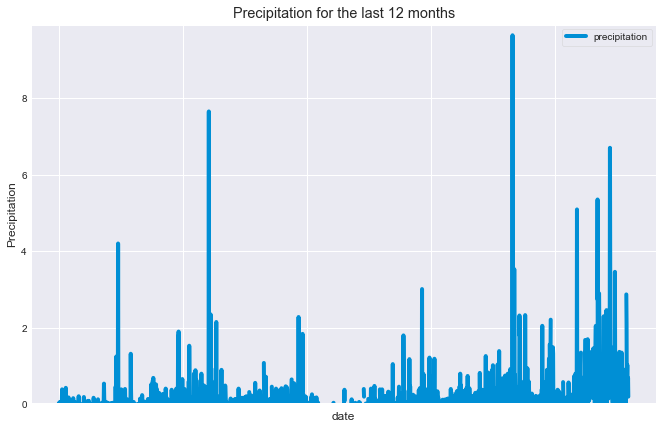

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
# Formatting was difficult
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,7))
TripPrcp_df.plot(ax=ax)

# #set major ticks format
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_ylim(0,max(TripPrcp_df['precipitation']+.3))
ax.set_title("Precipitation for the last 12 months")
ax.set_ylabel("Precipitation")
ax.set_xlabel("date")
plt.xticks(rotation=45)
plt.savefig("12 Month Precipitation.png")
plt.show()


In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
TripPrcp_df.describe()

,precipitation
count,2057.000000
mean,0.176753
std,0.504169
min,0.000000
25%,0.000000
50%,0.020000
75%,0.140000
max,9.640000


In [20]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement).group_by(Measurement.station).count()

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Active_Station = session.query(Measurement.station,func.count(Measurement.id)).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).statement

Active_df = pd.read_sql_query(Active_Station, session.bind)

Active_df.head()

,station,count_1
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
min = session.query(func.min(Measurement.tobs)).scalar()
max = session.query(func.max(Measurement.tobs)).scalar()
avg = session.query(func.avg(Measurement.tobs)).scalar()
print(f"{min} is the lowest temperature, {max} is the highest temperature, {avg} is the average temperature")

53.0 is the lowest temperature, 87.0 is the highest temperature, 73.09795396419437 is the average temperature


In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Most_Active_St = Active_df["station"][0]
Temps = session.query(Measurement.tobs).filter(Measurement.date > Start).filter(Measurement.date < Finish).filter(Measurement.station == Most_Active_St).statement

Temp_df = pd.read_sql_query(Temps, session.bind)
Temp_df.head()

,tobs
0,72.0
1,75.0
2,73.0
3,74.0
4,75.0


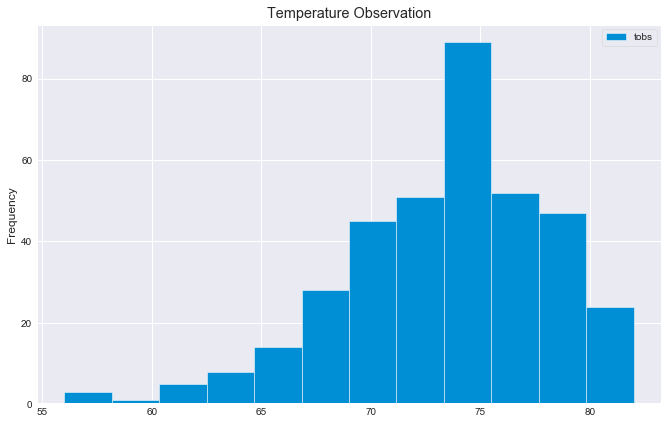

In [24]:
#histogram 
sns.set_style(style="darkgrid")
ax = Temp_df.plot(kind="hist",bins=12,figsize=(10,7))

ax.set_title("Temperature Observation")
ax.set_ylabel("Frequency")
plt.savefig("Frequency and TmpObs.png")
plt.show()

In [50]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    Beginning = dt.date(*(int(s) for s in start_date.split('-')))
    End = dt.date(*(int(s) for s in end_date.split('-')))

    calc = session.query(func.avg(Measurement.tobs),func.max(Measurement.tobs),func.min(Measurement.tobs)).\
    filter(Measurement.date > Beginning).filter(Measurement.date < End).statement  
    
# function usage example
print(calc_temps('2014-11-29', '2015-11-28'))

None


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
